# Setup

## Download the repo

In [2]:
# !git clone https://github.com/YuanGongND/ssast.git
!git clone https://github.com/roeizig/ssast.git

Cloning into 'ssast'...
remote: Enumerating objects: 7800, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 7800 (delta 110), reused 140 (delta 66), pack-reused 7556
Receiving objects: 100% (7800/7800), 790.70 MiB | 26.64 MiB/s, done.
Resolving deltas: 100% (605/605), done.
Checking out files: 100% (8748/8748), done.


## Install requirements

In [3]:
!cd ssast/
!pip install -r /content/ssast/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [4]:
import torch
import torchaudio
from PIL import Image
import numpy as np
from ssast.src.models.ast_models import *
from tqdm.notebook import tqdm_notebook
import time
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import output
output.enable_custom_widget_manager()

# output.disable_custom_widget_manager()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Overriding the model

## New model definition

In [5]:
from ssast.src.models.ast_models import ASTModel

class ASTModelRoei(ASTModel):
    def __init__(self):
      super().__init__(fshape=16, tshape=16, fstride=10, tstride=10, 
                      input_fdim=128, input_tdim=1024, model_size='tiny', 
                      pretrain_stage=False, load_pretrained_mdl_path='/content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth')
      # regressor head for fine-tuning / inference
      # self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
      #                               nn.Linear(self.original_embedding_dim, 1))
      self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
                                    nn.Linear(self.original_embedding_dim, 1))


    def finetuning_regressor(self, x, y, loss_method = 'L1'):
        # Finetuning using the regressor task.
        # Calculate MSE loss and update weights accordingly
        # B = x.shape[0]

        # Calculate RMSE loss and update weights
        pred = self.regressor(x)
        target = y
        # If cannot use reference in a vectorized manner, use the for loop below
        # pred = torch.empty((B), device=x.device).float()  # e.g. size 12 for a batch of 12 spectrograms
        # target = torch.empty((B), device=x.device).float() # e.g. size 12 for a batch of 12 spectrograms
        # for i in range(B):
        #     #  +2 for indexes because of cls and dis token
        #     pred[i] = self.regressor(x[i])
        #     target[i] = y[i]
        # calculate the RMSE loss
        # rmse = torch.mean((pred - target) ** 2)**0.5

        # Update weights according to MSE loss
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        optimizer.zero_grad()
        criterion = nn.MSELoss() if loss_method == 'L2' else nn.L1Loss()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        return loss


    def regressor(self, x):
        # Copied from "finetuningavgtok"
        # changed only the last part, sending the intermediate result
        # to the regressor head instead of the mlp head.
        # Inference only mode
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.regressor_head(x)
        return x


    def forward(self, x, task = 'regressor', y=None, cluster=True, mask_patch=400, loss_method = 'L1'):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        # finetuning (ft), use the mean of all token (patch) output as clip-level representation.
        # this is default for SSAST fine-tuning as during pretraining, supervision signal is given to each token, not the [cls] token
        if task == 'ft_avgtok':
            return self.finetuningavgtok(x)
        # fine tuning the model as a regressor
        elif task == 'ft_regressor':
            return self.finetuning_regressor(x, y, loss_method)
        # inference using a regressor
        elif task == 'regressor':
            return self.regressor(x)
        # alternatively, use the [cls] token output as clip-level representation.
        elif task == 'ft_cls':
            return self.finetuningcls(x)
        # pretraining, masked patch classification (discriminative objective)
        elif task == 'pretrain_mpc':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster)
        # pretraining, masked patch reconstruction (generative objective)
        elif task == 'pretrain_mpg':
            return self.mpg(x, mask_patch=mask_patch, cluster=cluster)
        elif task == 'visualize_mask':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster, show_mask=True)
        else:
            raise Exception('Task unrecognized.')



## Creating the overridden model

In [3]:
# new_model = ASTModelRoei()
# new_model.eval()
# new_model.to(device)

## Creating the dataset

In [6]:
## Creating Dataset
from random import sample
from torch.utils.data import Dataset, DataLoader
import os
import math
from torchvision import transforms


class SpectrogramData(Dataset):
    
    def __init__(self, audio_dir, device):
        self.audio_dir = audio_dir
        self.device = device
        self._create_ann()
        self.transform = transforms.PILToTensor()

        
    def __len__(self):
        return len(self.annotations[0])
        

    def __getitem__(self, index):
        sample_path = self._get_sample_path(index)
        label = float(self._get_sample_label(index))

        signal = Image.open(sample_path)
        signal = self.transform(signal)
        signal = signal.to(self.device, dtype=torch.float)
        return signal, label, index

            
    def _create_ann(self, path="ssast/spectrogram_images_V3a/"):
        Ann = [[],[],[]]
        for subdir, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('png'):
                                Ann[0].append(file) ##name
                                Ann[1].append(subdir) #folder
                                tmp_label = file.split('_')[-1]
                                Ann[2].append(float(tmp_label[:-4])) #label
        Ann = np.asarray(Ann)
        self.annotations = Ann


    def shuffle(self):
      perm = torch.randperm(len(self.annotations[0]))
      self.annotations= self.annotations[:,perm]
      pass    
    

    def _get_sample_path(self, index):
        folder = self.annotations[1][index]
        filename = self.annotations[0][index]
        path = os.path.join(self.audio_dir, folder, filename)
        return path
    

    def _get_sample_label(self, index):
        label = self.annotations[2][index]
        return label

##Functuins for DataViz
    def _index_from_label(self, query_label):
        labels =[float(x) for x in self.annotations[2]]
        query_label = np.asarray(query_label)
        diff = (np.abs(labels-query_label))
        # index = diff.argmin()
        index = np.where(diff == diff.min())
        # print(np.where(diff == diff.min()))
        # print(index)
        return index
        
    def seq_from_label(self, query, query_type = 'label'):
        
        if query_type == 'label':
          index = self._index_from_label(query)
          # print(index[0][0])
          index = index[0][0]
        else:
          index = query
        folder = self.annotations[1][index]
        current_call_filename = self.annotations[0][index]
        
        current_call_path = self._get_sample_path(index)
        current_call =Image.open(current_call_path)
        
        current_call_num = int(current_call_filename.split('_')[-3])
        prefix = '_'.join(current_call_filename.split('_')[:-3])

        next_call_prefix = '_'.join([prefix, str(current_call_num+1)])+'_'
        prev_call_prefix = '_'.join([prefix, str(current_call_num-1)])+'_'
        
      
        next_call_filename= None
        prev_call_filename = None
        next_call = None
        prev_call = None
      
        for subdir, dirs, files in os.walk(folder):
          for file in files:
              if file.startswith(bytes(next_call_prefix,'utf-8')):
                              next_call_filename = file.decode()
                              next_call_path = os.path.join(folder, next_call_filename)
                              next_call = Image.open(next_call_path)
              if file.startswith(bytes(prev_call_prefix,'utf-8')):
                              prev_call_filename = file.decode()
                              prev_call_path = os.path.join(folder, prev_call_filename)
                              prev_call = Image.open(prev_call_path)
        
        images = [prev_call, current_call, next_call]
        names  = [prev_call_filename, current_call_filename, next_call_filename]

        for i, (img,name) in enumerate(zip(images, names)):
          if img:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            plt.imshow(img, origin = 'lower')
            plt.title(name)
            plt.show()
          else:
            if i == 0:
              print(f'previous call does not exist')
            else:
              print(f'next call does not exist')

        return images, names




In [7]:
path = "ssast/spectrogram_images_V3a/"
x = SpectrogramData("", device)
print(len(x))
trainval , testset = torch.utils.data.random_split(x, [2000, len(x)-2000],
                                            generator=torch.Generator().manual_seed(42))
trainset, valset = torch.utils.data.random_split(trainval, [1500, 500],
                                                generator=torch.Generator().manual_seed(42))

2061


In [6]:
# ##Testing the sequence display
# label = 52.2493
# # label = 60
# images, names = x.seq_from_label(label)

## Testing the model on a single spectrogram

In [7]:
# xx = x[1]
# pred = new_model(xx[0], task='regressor')
# label = xx[-1]
# print(pred)
# print(label)

In [8]:
# new_model(spectgram.unsqueeze(0).to(dtype=torch.float), task='ft_regressor', y=torch.Tensor([[float(xx[-1])]]))

# Training the Model

In [8]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


In [ ]:
# torch.cuda.empty_cache()

In [9]:
def train_loop(trainloader, valloader, model, epochs = 30, loss_method = 'L2'):
  model = model.to(device)
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []
  for e in range(epochs):
      running_loss = 0
      train_correct = 0
      model.train()
      for images, labels,_ in tqdm_notebook(trainloader):

          images = images.to(device, dtype=torch.float)
          labels = labels.to(device, dtype=torch.float)
          loss = model(images.squeeze(1), task='ft_regressor', y=labels.unsqueeze(-1), loss_method = loss_method)
          loss = loss.item()
          
          # print(loss)
          running_loss += loss
          # ##evaluating without dropout
          # with torch.no_grad():
          #   model.eval()
          #   logits = model(images.to(device))
          #   ps = torch.softmax(logits,dim=1)
          #   top_ps, top_class = ps.topk(1,dim=1)
          #   train_equals_batch = top_class == (labels.view(*top_class.shape))
          #   train_correct +=train_equals_batch.sum().item()
          
          # model.train()
          
          
      else:
          running_val_loss = 0
          val_correct = 0
          
          with torch.no_grad():
              model.eval()
              for images, labels,_ in tqdm_notebook(valloader):  
                  images = images.to(device, dtype=torch.float)
                  labels = labels.to(device, dtype=torch.float)
                  pred = model(images.squeeze(1), task='regressor', y=labels.unsqueeze(-1), loss_method = loss_method)
                  criterion = nn.MSELoss() if loss_method == 'L2' else nn.L1Loss()
                  loss = criterion(pred, labels.unsqueeze(-1).to(device, dtype = float))
                  loss = loss.item()
                  running_val_loss += loss

                  # ps = torch.softmax(logits, dim=1)
                  # top_ps, top_class = ps.topk(1,dim=1)
                  # equals_batch = top_class == labels.view(*top_class.shape)
                  # test_correct +=equals_batch.sum().item()
              model.train()
          
          training_loss = running_loss/len(trainloader)
          val_loss = running_val_loss/len(valloader)
          train_accuracy = 0 # train_correct/len(trainloader.dataset)
          val_accuracy = 0 #test_correct/len(testloader.dataset)
          if e>0:
            if val_loss<min(val_losses):
              print('saving model...')
              torch.save(model.state_dict(),'model.pth')

          
          train_losses.append(training_loss)
          val_losses.append(val_loss)
          train_accs.append(train_accuracy)
          val_accs.append(val_accuracy)
          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(training_loss),
                "Test Loss: {:.3f}.. ".format(val_loss))
  return train_losses, train_accs, val_losses, val_accs  

In [10]:
new_model = ASTModelRoei()
new_model.to(device)
trainloss,trainacc,valloss,valacc = train_loop(trainloader, valloader, model = new_model, epochs = 100, loss_method = 'L2')


now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


  0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1/100..  Training Loss: 1256.374..  Test Loss: 531.505.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 2/100..  Training Loss: 168.142..  Test Loss: 16.592.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 3/100..  Training Loss: 16.558..  Test Loss: 11.189.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 4/100..  Training Loss: 11.619..  Test Loss: 7.730.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5/100..  Training Loss: 10.858..  Test Loss: 9.870.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6/100..  Training Loss: 9.708..  Test Loss: 10.188.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7/100..  Training Loss: 8.532..  Test Loss: 9.599.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 8/100..  Training Loss: 7.726..  Test Loss: 6.905.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9/100..  Training Loss: 7.851..  Test Loss: 7.642.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 10/100..  Training Loss: 7.061..  Test Loss: 6.481.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11/100..  Training Loss: 7.116..  Test Loss: 6.774.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 12/100..  Training Loss: 6.937..  Test Loss: 5.862.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13/100..  Training Loss: 5.991..  Test Loss: 7.004.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14/100..  Training Loss: 6.187..  Test Loss: 6.027.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15/100..  Training Loss: 5.990..  Test Loss: 5.999.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 16/100..  Training Loss: 6.024..  Test Loss: 6.141.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 17/100..  Training Loss: 5.454..  Test Loss: 5.989.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 18/100..  Training Loss: 5.699..  Test Loss: 6.451.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 19/100..  Training Loss: 5.520..  Test Loss: 6.436.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 20/100..  Training Loss: 5.306..  Test Loss: 8.983.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 21/100..  Training Loss: 5.379..  Test Loss: 6.629.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 22/100..  Training Loss: 5.142..  Test Loss: 7.163.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 23/100..  Training Loss: 5.076..  Test Loss: 4.971.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 24/100..  Training Loss: 5.306..  Test Loss: 7.498.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 25/100..  Training Loss: 5.224..  Test Loss: 5.063.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 26/100..  Training Loss: 5.007..  Test Loss: 4.680.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 27/100..  Training Loss: 4.641..  Test Loss: 4.889.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 28/100..  Training Loss: 5.227..  Test Loss: 5.616.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 29/100..  Training Loss: 4.858..  Test Loss: 6.587.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 30/100..  Training Loss: 4.774..  Test Loss: 7.818.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 31/100..  Training Loss: 4.765..  Test Loss: 5.452.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 32/100..  Training Loss: 4.759..  Test Loss: 6.910.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 33/100..  Training Loss: 4.533..  Test Loss: 6.013.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 34/100..  Training Loss: 4.289..  Test Loss: 5.133.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 35/100..  Training Loss: 4.580..  Test Loss: 7.863.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 36/100..  Training Loss: 4.490..  Test Loss: 5.014.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 37/100..  Training Loss: 4.301..  Test Loss: 6.349.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 38/100..  Training Loss: 4.264..  Test Loss: 5.507.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 39/100..  Training Loss: 4.191..  Test Loss: 4.889.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 40/100..  Training Loss: 4.038..  Test Loss: 4.913.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 41/100..  Training Loss: 4.296..  Test Loss: 4.502.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 42/100..  Training Loss: 4.331..  Test Loss: 6.538.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 43/100..  Training Loss: 4.130..  Test Loss: 4.550.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 44/100..  Training Loss: 3.875..  Test Loss: 4.693.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 45/100..  Training Loss: 4.215..  Test Loss: 5.470.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 46/100..  Training Loss: 4.760..  Test Loss: 6.483.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 47/100..  Training Loss: 4.151..  Test Loss: 4.922.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 48/100..  Training Loss: 3.890..  Test Loss: 5.095.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 49/100..  Training Loss: 3.780..  Test Loss: 6.873.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 50/100..  Training Loss: 3.783..  Test Loss: 5.369.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 51/100..  Training Loss: 3.750..  Test Loss: 4.857.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 52/100..  Training Loss: 3.760..  Test Loss: 4.531.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 53/100..  Training Loss: 4.246..  Test Loss: 7.301.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 54/100..  Training Loss: 3.775..  Test Loss: 4.507.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 55/100..  Training Loss: 3.451..  Test Loss: 4.784.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 56/100..  Training Loss: 3.602..  Test Loss: 7.670.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 57/100..  Training Loss: 3.872..  Test Loss: 5.168.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 58/100..  Training Loss: 3.510..  Test Loss: 4.218.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 59/100..  Training Loss: 3.358..  Test Loss: 4.434.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 60/100..  Training Loss: 3.503..  Test Loss: 4.637.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 61/100..  Training Loss: 3.386..  Test Loss: 4.681.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 62/100..  Training Loss: 3.484..  Test Loss: 4.713.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 63/100..  Training Loss: 3.182..  Test Loss: 4.741.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 64/100..  Training Loss: 3.319..  Test Loss: 5.016.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 65/100..  Training Loss: 3.389..  Test Loss: 6.509.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 66/100..  Training Loss: 3.596..  Test Loss: 5.974.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 67/100..  Training Loss: 3.512..  Test Loss: 4.218.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 68/100..  Training Loss: 3.443..  Test Loss: 5.041.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 69/100..  Training Loss: 3.392..  Test Loss: 4.625.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 70/100..  Training Loss: 3.079..  Test Loss: 4.642.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 71/100..  Training Loss: 3.424..  Test Loss: 4.938.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 72/100..  Training Loss: 3.127..  Test Loss: 5.664.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 73/100..  Training Loss: 3.066..  Test Loss: 4.568.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 74/100..  Training Loss: 3.102..  Test Loss: 4.333.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 75/100..  Training Loss: 3.011..  Test Loss: 4.779.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 76/100..  Training Loss: 3.167..  Test Loss: 4.345.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 77/100..  Training Loss: 3.183..  Test Loss: 4.241.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 78/100..  Training Loss: 2.995..  Test Loss: 5.646.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 79/100..  Training Loss: 3.183..  Test Loss: 4.515.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 80/100..  Training Loss: 3.119..  Test Loss: 4.338.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 81/100..  Training Loss: 3.016..  Test Loss: 4.547.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 82/100..  Training Loss: 2.954..  Test Loss: 4.625.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 83/100..  Training Loss: 3.063..  Test Loss: 5.256.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 84/100..  Training Loss: 2.707..  Test Loss: 4.482.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 85/100..  Training Loss: 2.920..  Test Loss: 5.154.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 86/100..  Training Loss: 2.985..  Test Loss: 4.734.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 87/100..  Training Loss: 2.777..  Test Loss: 4.258.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 88/100..  Training Loss: 2.770..  Test Loss: 4.439.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 89/100..  Training Loss: 2.986..  Test Loss: 4.781.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 90/100..  Training Loss: 3.236..  Test Loss: 5.138.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 91/100..  Training Loss: 3.111..  Test Loss: 4.644.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 92/100..  Training Loss: 3.331..  Test Loss: 4.965.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 93/100..  Training Loss: 2.886..  Test Loss: 5.018.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 94/100..  Training Loss: 3.023..  Test Loss: 4.185.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 95/100..  Training Loss: 2.889..  Test Loss: 4.805.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving model...
Epoch: 96/100..  Training Loss: 2.963..  Test Loss: 3.940.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 97/100..  Training Loss: 2.730..  Test Loss: 5.057.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 98/100..  Training Loss: 2.715..  Test Loss: 5.149.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 99/100..  Training Loss: 2.714..  Test Loss: 3.957.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 100/100..  Training Loss: 2.808..  Test Loss: 3.982.. 


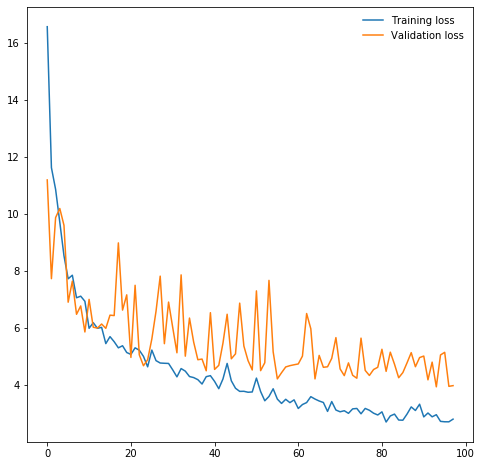

In [13]:
plt.figure(figsize = (8,8))
plt.plot(trainloss[2:],label = 'Training loss')
plt.plot(valloss[2:],label = 'Validation loss')
plt.legend(frameon=False)


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
# Save the model itself
# torch.save(new_model, 'model_30e_clean.pth')

# Save the model's weights
torch.save(new_model.state_dict(), 'model_weights_100e_V3.pth')

In [ ]:
# plt.figure(figsize = (8,8))
# plt.plot(trainloss,label = 'Training loss')
# plt.plot(valloss,label = 'Validation loss')
# plt.legend(frameon=False)

# # plt.figure(figsize = (8,8))
# # plt.plot(train_accs_d,label = 'Training Accuracy')
# # plt.plot(test_accs_d,label = 'Validation Accuracy')
# # plt.legend(frameon=False)

# Load an existing model

In [14]:
new_model = ASTModelRoei()
# new_model.load_state_dict(torch.load('/content/ssast/pretrained_model/model_weights_84e_L2_early_stop.pth'))
new_model.load_state_dict(torch.load('model.pth'))
new_model.eval()
new_model.to(device)

now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ASTModelRoei(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 192, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((19

# Analyze results

## Functions

In [15]:
def get_sample_results(model, dataset):
    data_size = len(dataset.indices)
    if data_size < 256:
        dataloader = DataLoader(dataset, batch_size=data_size,
                                shuffle=True, num_workers=0)
        images, labels, index = next(iter(dataloader))
        with torch.no_grad():
            model.eval()
            preds = model(images.squeeze(1).to(device, dtype=torch.float), task='regressor')
            diff = preds.squeeze().cpu() - labels.squeeze().cpu()
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    else:
        batch_size = 256
        dataloader = DataLoader(dataset, batch_size=batch_size,
                                shuffle=True, num_workers=0)
        labels = torch.tensor((), device=device)
        preds = torch.tensor((), device=device)
        diff = torch.tensor(())
        index = torch.tensor(())
        with torch.no_grad():
            model.eval()
            for batch_images, batch_labels, batch_index in dataloader:
                batch_images = batch_images.to(device, dtype=torch.float)
                batch_labels = batch_labels.to(device, dtype=torch.float)
                batch_preds = model(batch_images.squeeze(1), task='regressor')
                batch_diff = batch_preds.squeeze().cpu() - batch_labels.squeeze().cpu()
                labels = torch.cat([labels, batch_labels], dim=0)
                preds = torch.cat([preds, batch_preds], dim=0)
                diff = torch.cat([diff, batch_diff], dim=0)
                index = torch.cat([index, batch_index], dim=0)
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    print(f"Dataset RMSE is {rmse:.2f}")
    return pd.DataFrame({'pred': preds.cpu().squeeze(), 
                         'label': labels.cpu().squeeze(), 
                         'diff' :diff, 
                         'abs_diff': diff.abs(),
                         'index' : index})

In [16]:
def analyze_sample_results(stats_df):
    # Scatter plot with linear trend y=x
    lin_min = np.min([stats_df['pred'].min(), stats_df['label'].min()])
    lin_max = np.max([stats_df['pred'].max(), stats_df['label'].max()])
    plt.figure(figsize=(15, 9))
    plt.scatter(stats_df['label'], stats_df['pred'])
    plt.plot([lin_min, lin_max], [lin_min, lin_max], color='red')
    plt.title("Model prediction vs. label", size=18)
    plt.xlabel("Label", size=16)
    plt.ylabel("Prediction", size=16)
    plt.show()

    # Error histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['diff'], bins=100)
    plt.title("Model's error distribution", size=18)
    plt.xlabel("Error", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()


    # label histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['label'], bins=100)
    plt.title("GT distribution", size=18)
    plt.xlabel("label", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()

    # Diff statistics
    display(stats_df.describe([.1, .25, .5, .75, .9])[['abs_diff']].T)

## Test analysis

Dataset RMSE is 1.61


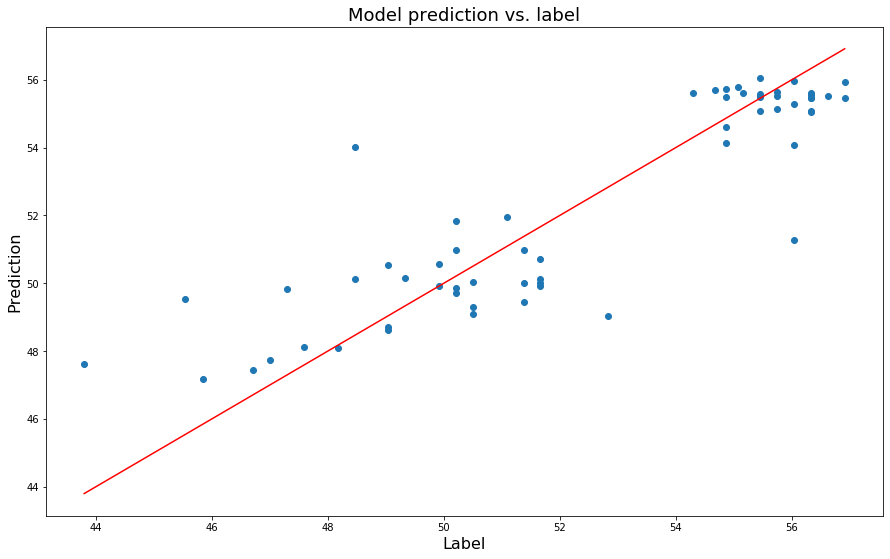

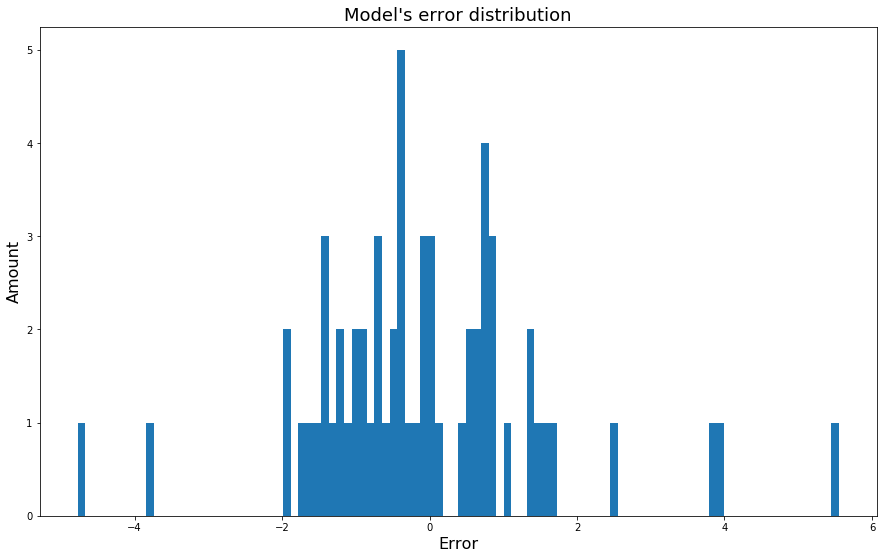

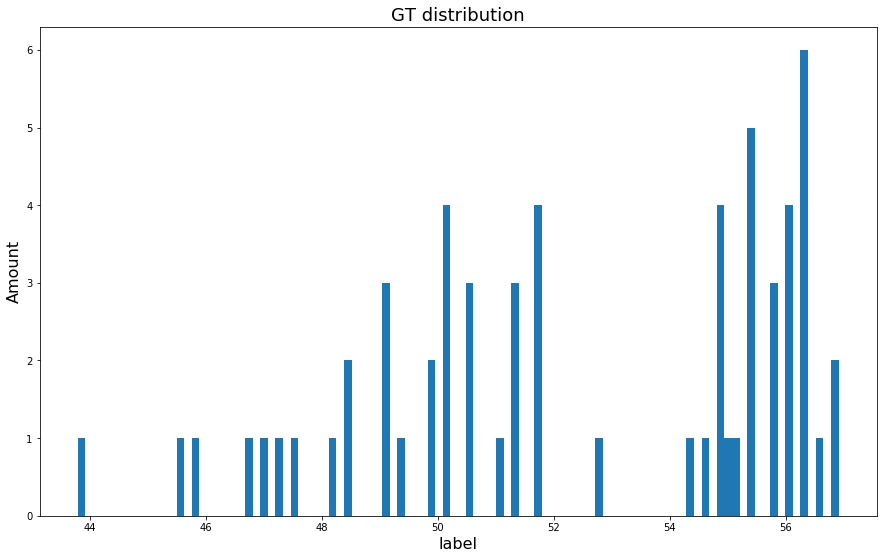

,count,mean,std,min,10%,25%,50%,75%,90%,max
abs_diff,61.0,1.150858,1.134279,0.011933,0.119741,0.478062,0.805456,1.394691,1.953073,5.546739


In [17]:
test_df = get_sample_results(new_model, testset)
analyze_sample_results(test_df)
torch.cuda.empty_cache()

## Train & Validation analysis

Dataset RMSE is 1.65


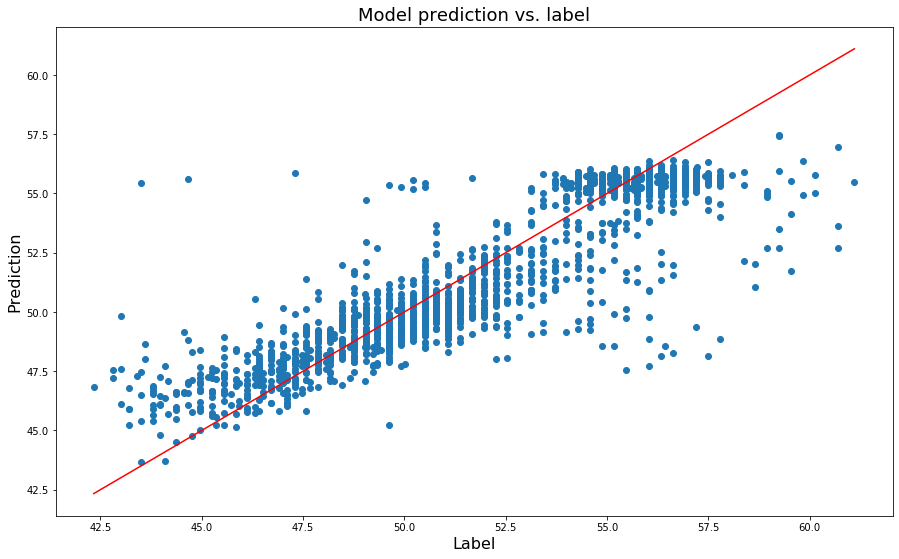

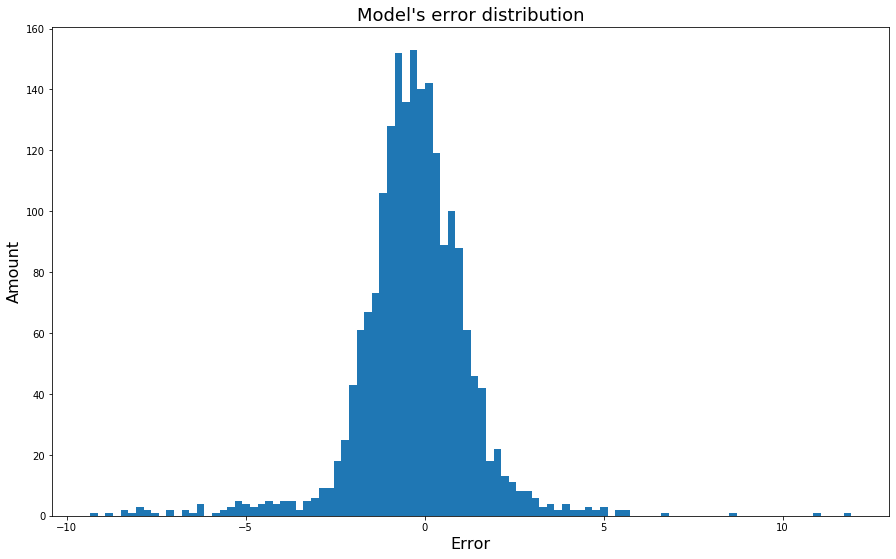

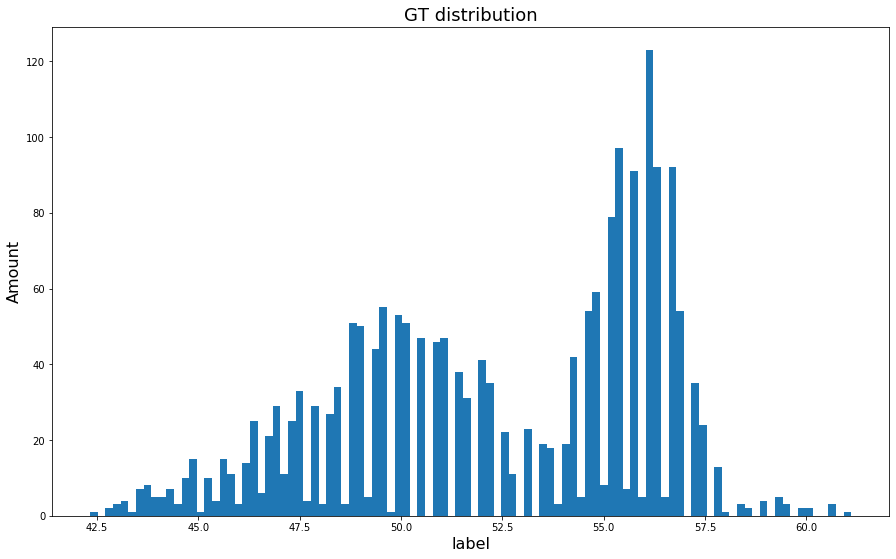

,count,mean,std,min,10%,25%,50%,75%,90%,max
abs_diff,2000.0,1.118259,1.2076,0.000275,0.157902,0.376716,0.816647,1.415062,2.1996,11.917225


In [18]:
trainval_df = get_sample_results(new_model, trainval)
analyze_sample_results(trainval_df)
torch.cuda.empty_cache()

## Find samples of largest error

 Search "label_{label}" in images folder for the actual image

In [16]:
(pd.concat([trainval_df,
           test_df],
          axis=0)
.sort_values('abs_diff', ascending=False).head(10))

,pred,label,diff,abs_diff,index
1856,55.378216,43.502899,11.875317,11.875317,1630.0
1690,55.916229,44.669102,11.247128,11.247128,1327.0
1268,54.702446,45.835300,8.867146,8.867146,1636.0
61,50.863029,59.537900,-8.674871,8.674871,1416.0
1043,49.058609,57.205502,-8.146893,8.146893,334.0
225,52.650139,60.704102,-8.053963,8.053963,93.0
286,55.334320,47.292999,8.041321,8.041321,745.0
1543,48.594273,56.330898,-7.736626,7.736626,431.0
1014,53.479362,60.704102,-7.224739,7.224739,100.0
1951,49.191124,56.039398,-6.848274,6.848274,1332.0


# Display sequences of largest errors


Error of 11.92
Pred: 55.42
3-Sequence of the respective images:
previous call does not exist


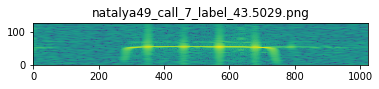

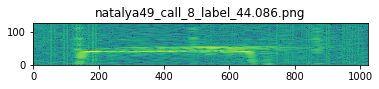


Error of 10.94
Pred: 55.61
3-Sequence of the respective images:


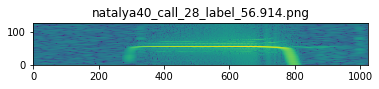

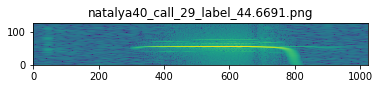

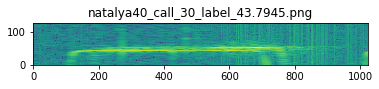


Error of -9.34
Pred: 48.16
3-Sequence of the respective images:
previous call does not exist


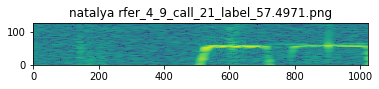

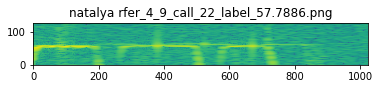


Error of -8.91
Pred: 48.88
3-Sequence of the respective images:


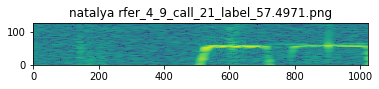

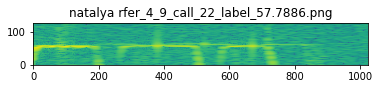

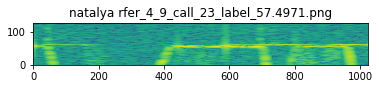


Error of 8.57
Pred: 55.86
3-Sequence of the respective images:


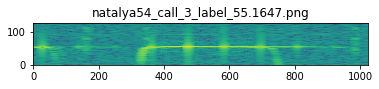

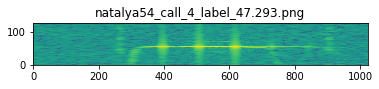

next call does not exist

Error of -8.33
Pred: 48.29
3-Sequence of the respective images:


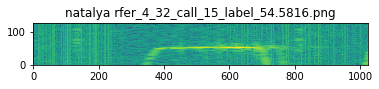

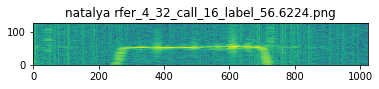

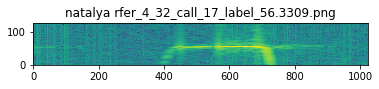


Error of -8.31
Pred: 47.73
3-Sequence of the respective images:


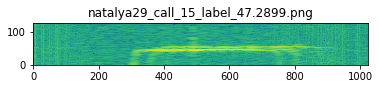

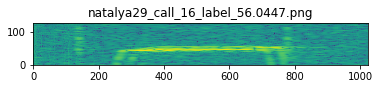

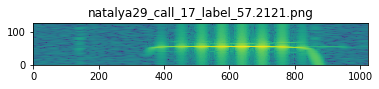


Error of -8.18
Pred: 48.15
3-Sequence of the respective images:


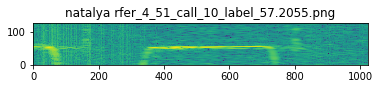

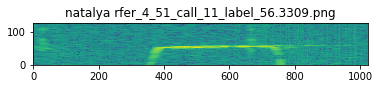

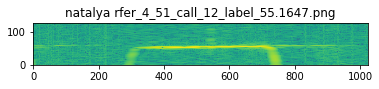


Error of -8.02
Pred: 52.68
3-Sequence of the respective images:


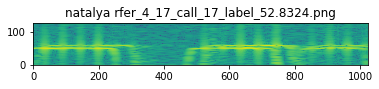

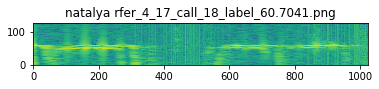

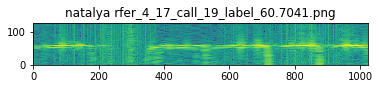


Error of -7.89
Pred: 47.57
3-Sequence of the respective images:


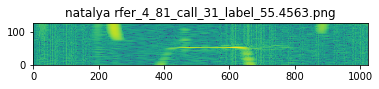

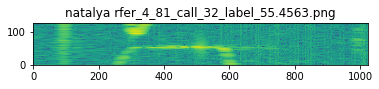

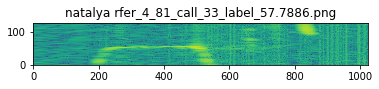


Error of -7.89
Pred: 48.55
3-Sequence of the respective images:


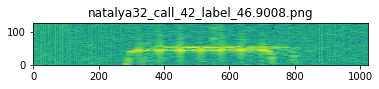

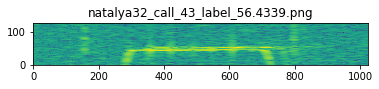

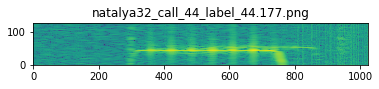


Error of -7.83
Pred: 49.38
3-Sequence of the respective images:
previous call does not exist


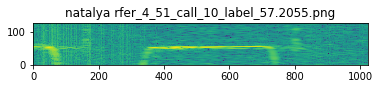

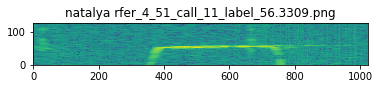


Error of -7.82
Pred: 51.72
3-Sequence of the respective images:
previous call does not exist


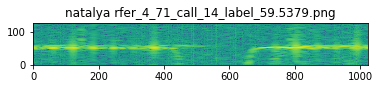

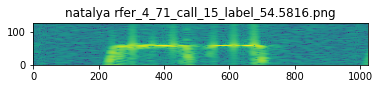


Error of -7.63
Pred: 51.04
3-Sequence of the respective images:


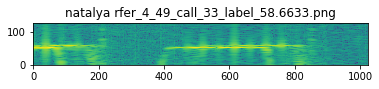

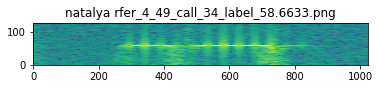

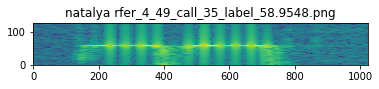


Error of -7.16
Pred: 48.88
3-Sequence of the respective images:
previous call does not exist


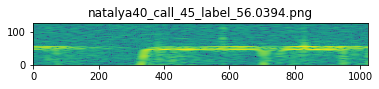

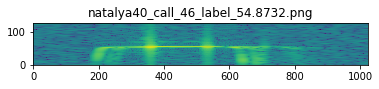

In [19]:
for row in (pd.concat([trainval_df, test_df], axis=0).sort_values('abs_diff', ascending = False).head(15)).iterrows():
    print(f"Error of {row[1]['diff']:.2f}")
    print(f"Pred: {row[1]['pred']:.2f}")
    print("3-Sequence of the respective images:")
    x.seq_from_label(int(row[1]['index']), query_type = 'index')
    print()

# Explain The model behavior

In [20]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

def rollout(attentions, discard_ratio, head_fusion):
    print('test')
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 2 :]
    print(mask.size())
    # In case of 224x224 image, this brings us from 196 to 14
    # width = int(mask.size(-1)**0.5)
    mask = mask.reshape(12, 101).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)
            print(output.size())
            print(self.attentions[0].size())
            print(self.discard_ratio)
            print(self.head_fusion)
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)


def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    img = img
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

torch.Size([1, 1])
torch.Size([1, 3, 1214, 1214])
0.999
max
test
torch.Size([1212])


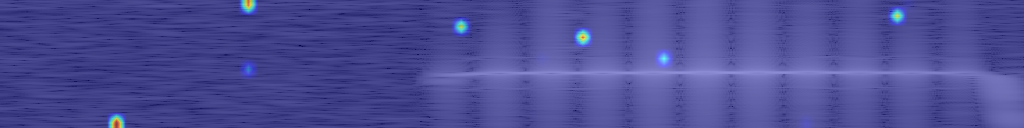

In [33]:
from google.colab.patches import cv2_imshow
# import vit_grad_roll
# from ssast.vit_grad_rollout import VITAttentionGradRollout
# from ssast.vit_rollout import VITAttentionRollout

dataloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
images, labels, index = next(iter(dataloader))
new_model.eval()
query = images.squeeze(1).to(device, dtype=torch.float)

rollout_vis = VITAttentionRollout(new_model, discard_ratio=0.999, head_fusion='max')
small_mask = rollout_vis(query)


query_image = query.squeeze().cpu().numpy()
query_image = np.dstack([query_image]*3)

big_mask = cv2.resize(small_mask, (query_image.shape[1], query_image.shape[0]))
masked_image = show_mask_on_image(query_image, big_mask)
cv2_imshow(masked_image)

In [34]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()

44

In [ ]:
query_image = query.squeeze().cpu().numpy()
query_image = np.dstack([query_image]*3)

big_mask = cv2.resize(small_mask, (query_image.shape[1], query_image.shape[0]))
masked_image = show_mask_on_image(query_image, big_mask)
plt.imshow(masked_image)
plt.show()

(128, 1024)


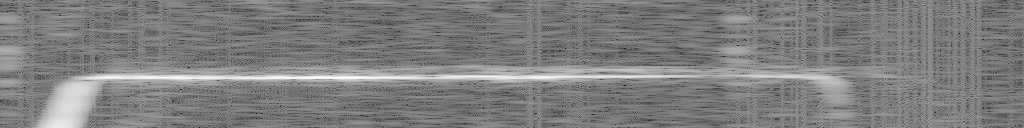

In [28]:
print(query.squeeze().cpu().numpy().shape)
cv2_imshow(query.squeeze().cpu().numpy())

In [ ]:
for name in model.named_modules():
  print (name)